In [67]:
from autogluon.tabular import TabularDataset, TabularPredictor
from ray import tune
import numpy as np
import math

In [68]:
#import data from Data/phil_socdata_train.csv, normalize (between 0 and 1) and standardize
train_data = TabularDataset('Data/phil_socdata_train.csv')

# drop the "T" column as it doesnt help with the prediction
train_data = train_data.drop(labels=['T'],axis=1)
train_data.head()


Loaded data from: Data/phil_socdata_train.csv | Columns = 7 / 7 | Rows = 421709 -> 421709


,SOC,V,I,P,V_avg,I_avg
0,100.000031,400.125,-1.50,-600.187500,400.125,-1.50
1,100.000031,400.125,-1.56,-624.195042,400.125,-1.53
2,100.000031,400.125,-1.62,-648.202585,400.125,-1.56
3,100.000031,400.125,-1.68,-672.210127,400.125,-1.59
4,100.000031,400.125,-1.74,-696.217669,400.125,-1.62


In [69]:
label = 'SOC'
train_data[label].describe()

count    421709.000000
mean         68.186101
std          24.503003
min           0.000000
25%          49.019623
50%          73.333359
75%          89.019638
max         100.000031
Name: SOC, dtype: float64

In [70]:
time_limit = 60  # train various models for x minutes

predictor = TabularPredictor(label=label).fit(
    train_data, 
    time_limit=time_limit, 
    presets='best_quality'
)



No path specified. Models will be saved in: "AutogluonModels/ag-20230412_051505/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/ag-20230412_051505/"
AutoGluon Version:  0.7.0
Python Version:     3.10.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #148-Ubuntu SMP Mon Oct 17 16:02:06 UTC 2022
Train Data Rows:    421709
Train Data Columns: 5
Label Column: SOC
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (100.000030517578, 0.0, 68.1861, 24.503)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regr

In [71]:
# import test data from Data/phil_socdata_test.csv, normalize (between 0 and 1) and standardize
test_data1 = TabularDataset(f'Data/phil_socdata_test1.csv')
test_data2 = TabularDataset(f'Data/phil_socdata_test2.csv')

y_pred1= predictor.predict(test_data1.drop(columns=[label]))
y_pred1.head()

y_pred2= predictor.predict(test_data2.drop(columns=[label]))
y_pred2.head()

Loaded data from: Data/phil_socdata_test1.csv | Columns = 7 / 7 | Rows = 18307 -> 18307
Loaded data from: Data/phil_socdata_test2.csv | Columns = 7 / 7 | Rows = 5617 -> 5617


0    50.852482
1    50.354008
2    50.354008
3    50.825562
4    50.825562
Name: SOC, dtype: float32

In [72]:
predictor.evaluate(test_data1, silent=True)

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -2.1621481337047506,
 'mean_squared_error': -4.674884552082936,
 'mean_absolute_error': -1.6890832279331054,
 'r2': 0.992770217448771,
 'pearsonr': 0.9982640204846892,
 'median_absolute_error': -1.331333156240234}

In [73]:
predictor.evaluate(test_data2, silent=True)

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -1.2075354430352023,
 'mean_squared_error': -1.4581418461862221,
 'mean_absolute_error': -0.8715584910653124,
 'r2': 0.9920251509856495,
 'pearsonr': 0.9960225243028472,
 'median_absolute_error': -0.6097984357421851}

In [74]:
predictor.leaderboard(test_data1, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-2.162148,-2.011363,0.846532,14.545468,14.960694,0.846532,14.545468,14.960694,1,True,1
1,WeightedEnsemble_L2,-2.162148,-2.011363,0.848635,14.549273,14.978608,0.002103,0.003806,0.017915,2,True,2
2,LightGBMXT_BAG_L2,-24.807850,-23.358851,0.863630,14.571899,15.791717,0.017097,0.026431,0.831023,2,True,3
3,WeightedEnsemble_L3,-24.807850,-23.358851,0.865225,14.577105,15.807261,0.001595,0.005207,0.015544,3,True,4


In [75]:
predictor.leaderboard(test_data2, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,-1.207535,-2.011363,0.431536,14.545468,14.960694,0.431536,14.545468,14.960694,1,True,1
1,WeightedEnsemble_L2,-1.207535,-2.011363,0.433230,14.549273,14.978608,0.001694,0.003806,0.017915,2,True,2
2,LightGBMXT_BAG_L2,-33.709929,-23.358851,0.443361,14.571899,15.791717,0.011825,0.026431,0.831023,2,True,3
3,WeightedEnsemble_L3,-33.709929,-23.358851,0.444883,14.577105,15.807261,0.001522,0.005207,0.015544,3,True,4


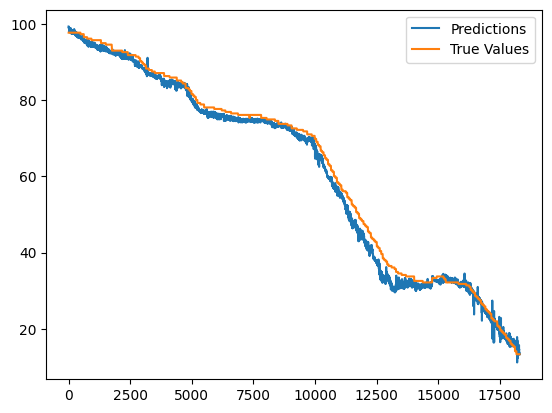

In [76]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred1, label="Predictions")
plt.plot(test_data1[label], label="True Values")
plt.legend()
plt.show()

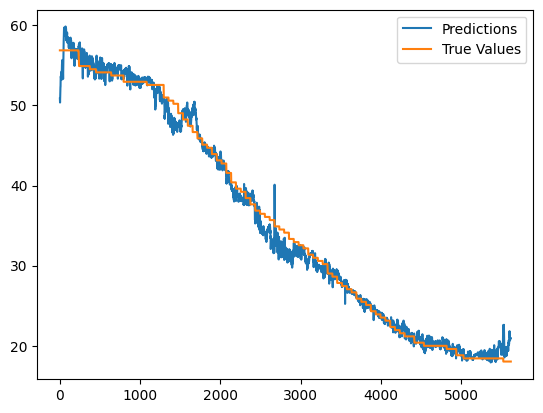

In [77]:
plt.plot(y_pred2, label="Predictions")
plt.plot(test_data2[label], label="True Values")
plt.legend()
plt.show()

In [78]:
mse_test = np.mean(((y_pred1 - test_data1[label])**2))
rmse_test = math.sqrt(mse_test)
print("Test data 1 RMSE", rmse_test)
mse_test = np.mean(((y_pred2 - test_data2[label])**2))
rmse_test = math.sqrt(mse_test)
print("Test data 2 RMSE", rmse_test)

Test data 1 RMSE 2.1621481337047506
Test data 2 RMSE 1.2075354430352023


In [79]:
predictor.feature_importance(test_data1)

These features in provided data are not utilized by the predictor and will be ignored: ['T']
Computing feature importance via permutation shuffling for 5 features using 5000 rows with 5 shuffle sets...
	12.15s	= Expected runtime (2.43s per shuffle set)
	6.54s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V_avg,22.895500,0.241814,1.492949e-09,5,23.393399,22.397601
V,15.469730,0.233518,6.228687e-09,5,15.950546,14.988914
I_avg,4.339484,0.101458,3.583089e-08,5,4.548387,4.130580
P,1.052621,0.017797,9.801655e-09,5,1.089265,1.015977
I,0.359091,0.006387,1.200162e-08,5,0.372241,0.345941


In [80]:
predictor.feature_importance(test_data2)

These features in provided data are not utilized by the predictor and will be ignored: ['T']
Computing feature importance via permutation shuffling for 5 features using 5000 rows with 5 shuffle sets...
	10.1s	= Expected runtime (2.02s per shuffle set)
	6.3s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V_avg,13.856129,0.310555,3.026069e-08,5,14.495567,13.216691
V,5.321838,0.122426,3.358354e-08,5,5.573915,5.069760
I_avg,4.956518,0.036638,3.582548e-10,5,5.031957,4.881079
P,1.786866,0.017606,1.130755e-09,5,1.823116,1.750615
I,0.381096,0.015736,3.480251e-07,5,0.413496,0.348696
